### Problem Statement
Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question.

### Dataset Description
1. id - the id of a training set question pair
2. qid1, qid2 - unique ids of each question (only available in train.csv)
3. question1, question2 - the full text of each question
4. is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

In [1]:
import zipfile

z= zipfile.ZipFile('../input/quora-question-pairs/train.csv.zip')
z.extractall()
z= zipfile.ZipFile('../input/quora-question-pairs/test.csv.zip')
z.extractall()

In [2]:
import nltk
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import warnings as wg
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import plot_confusion_matrix, log_loss

from nltk.stem import WordNetLemmatizer
import spacy
from tqdm import tqdm

import vaex
from vaex.ml.sklearn import IncrementalPredictor
from collections import Counter, defaultdict
wg.filterwarnings("ignore")

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [3]:
df = pd.read_csv("./train.csv")
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0


In [4]:
# df[~df['Unnamed: 8'].isna()]

In [5]:
# df = df.drop(["Unnamed: 6", "Unnamed: 7", "Unnamed: 8", "Unnamed: 9", "Unnamed: 10", "Unnamed: 11", 
#          "Unnamed: 12"], axis = 'columns')

In [6]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [7]:
df.shape

(404290, 6)

In [8]:
df.nunique()

id              404290
qid1            290654
qid2            299364
question1       290456
question2       299174
is_duplicate         2
dtype: int64

In [9]:
df.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
df["is_duplicate"].value_counts()

0    255027
1    149263
Name: is_duplicate, dtype: int64

In [12]:
df.loc[75, "question1"], df.loc[75, "question2"], df.loc[75, "is_duplicate"]

('If I fire a bullet backward from an aircraft going faster than the bullet; will the bullet be going backwards?',
 'Do bullets travel faster than the speed of sound when shot from a gun? If not, is it possible? If they do, what gun and how much devastation occurs?',
 0)

# Exploratory Data Analysis

<AxesSubplot:>

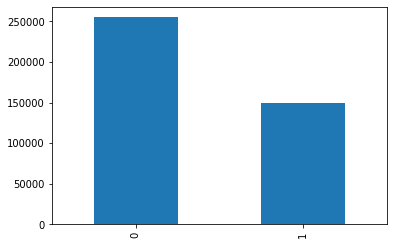

In [13]:
df["is_duplicate"].value_counts().plot(kind = "bar")

In [14]:
df.shape

(404290, 6)

In [15]:
df.nunique()

id              404290
qid1            290654
qid2            299364
question1       290456
question2       299174
is_duplicate         2
dtype: int64

In [16]:
text1 = " ".join(review for review in df.question1.astype(str))

In [17]:
print ("There are {} words in the combination of all cells in column 'question1'.".format(len(text1)))

There are 24474388 words in the combination of all cells in column 'question1'.


In [18]:
stop_words = set(STOPWORDS)
wordcloud1 = WordCloud(stopwords=stop_words, background_color="black", width=800, height=400).generate(text1)

**Common words in question1 column**

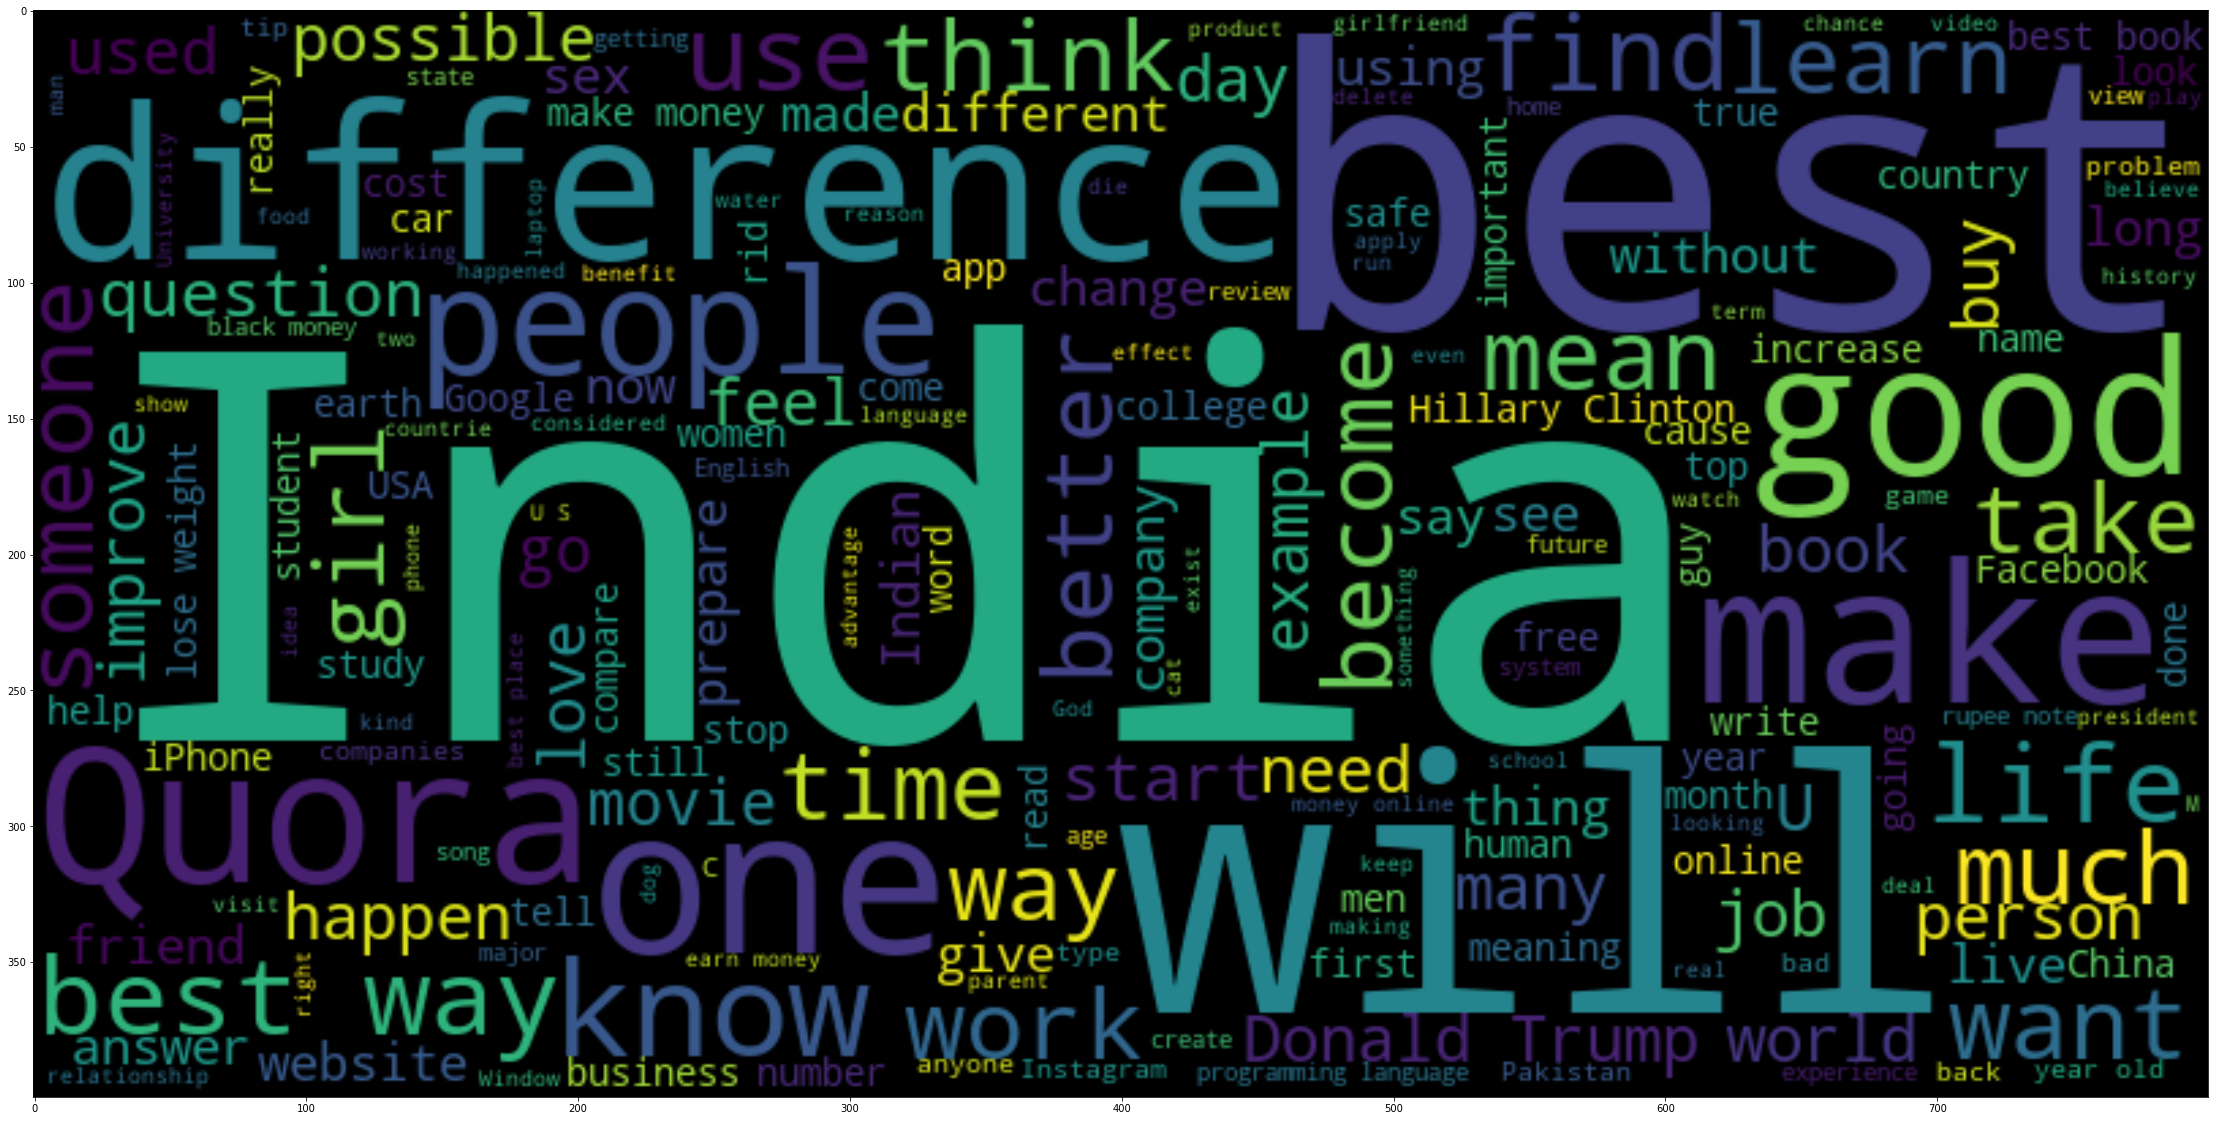

In [19]:
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.show()

In [20]:
text2 = " ".join(review for review in df.question2.astype(str))
print ("There are {} words in the combination of all cells in column 'question1'.".format(len(text2)))

There are 24705506 words in the combination of all cells in column 'question1'.


In [21]:
wordcloud2 = WordCloud(stopwords=stop_words, background_color="black", width=800, height=400).generate(text2)

![](http://)**Common words in question2 column**

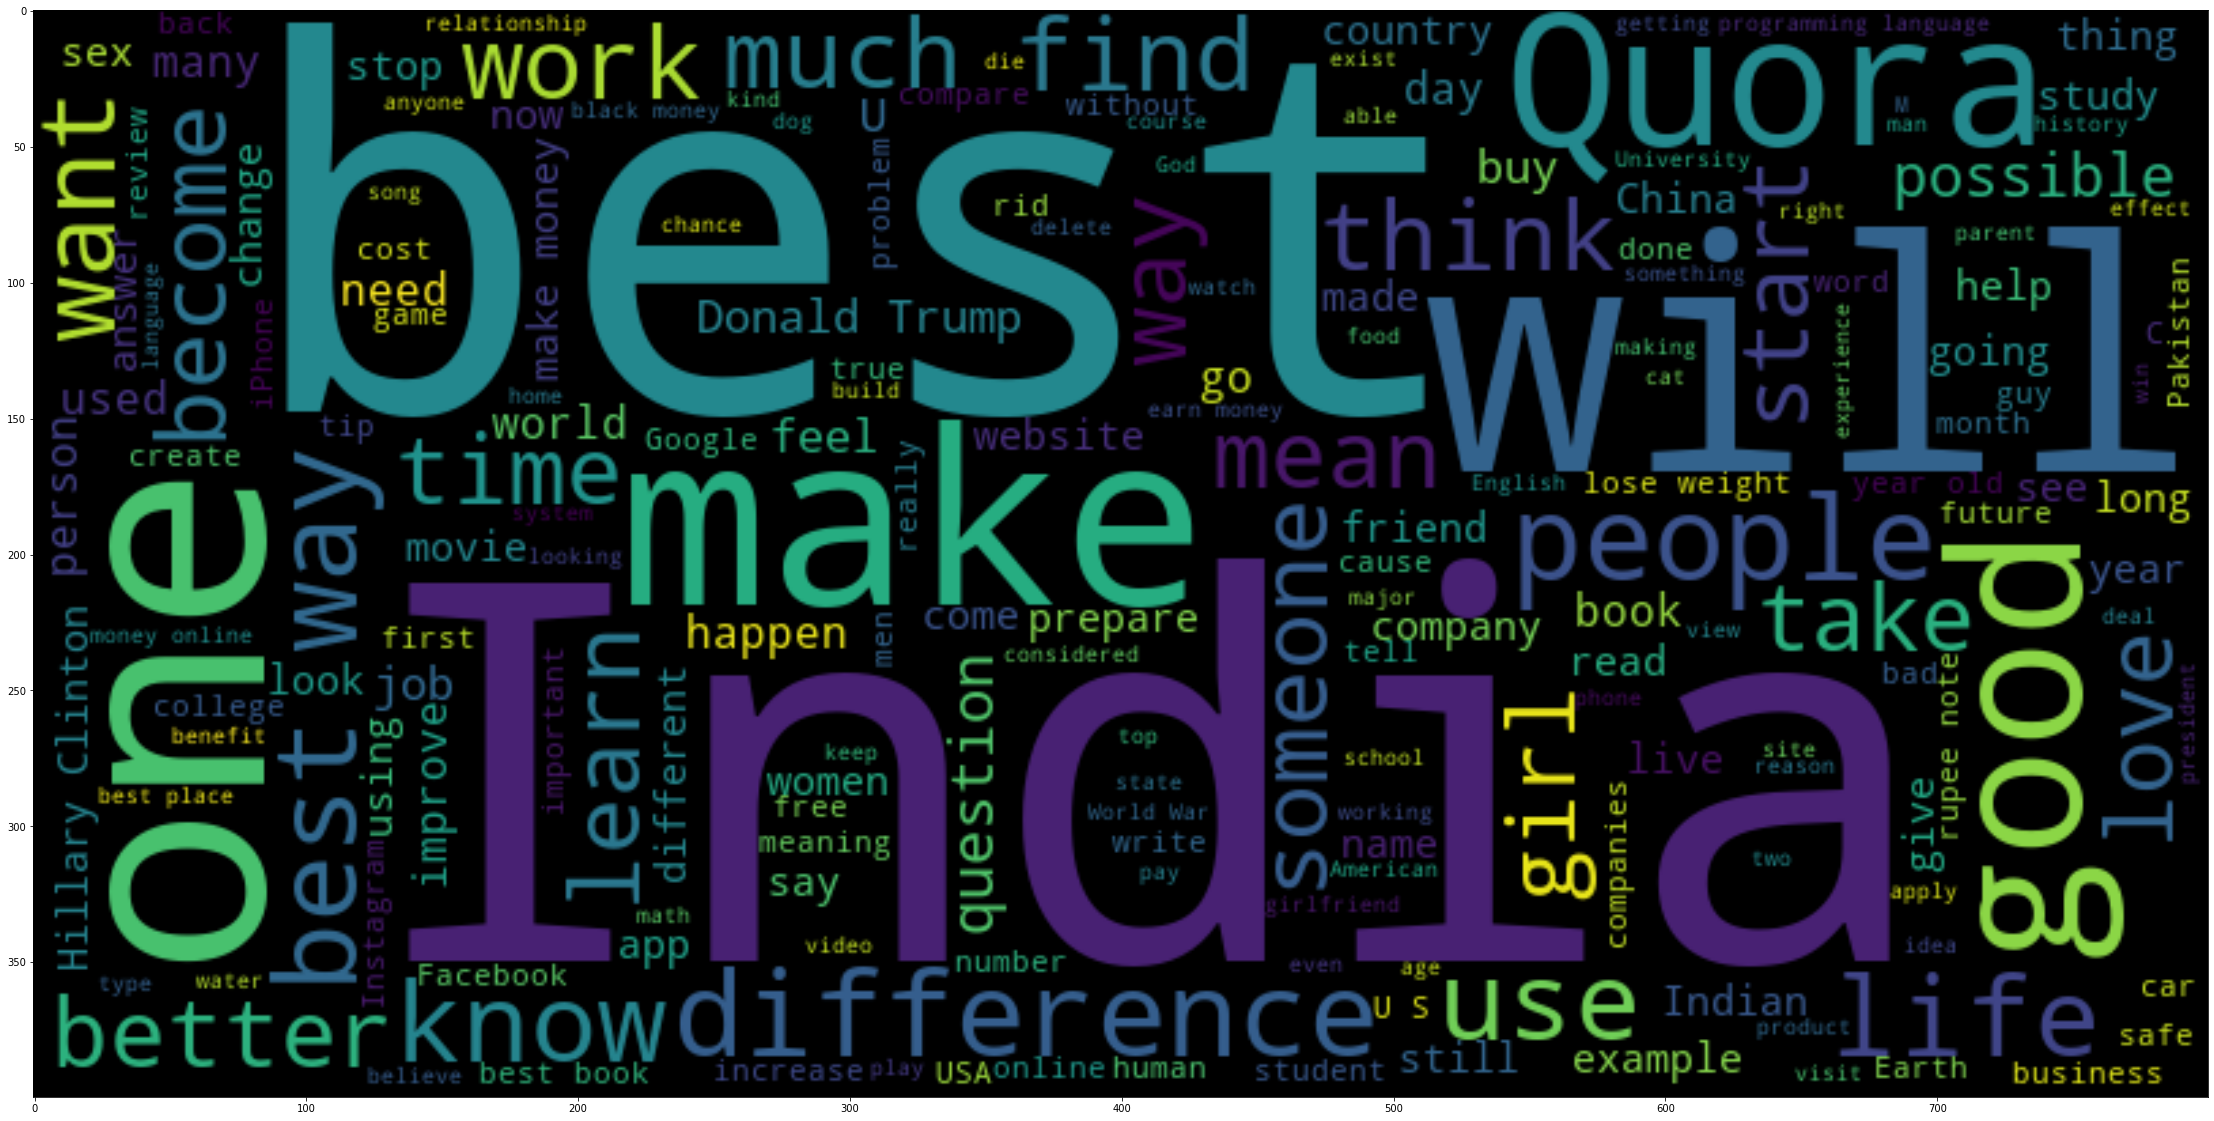

In [22]:
plt.figure(figsize=(40,20))
plt.tight_layout(pad=0)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.show()

# Feature Engineering

In [23]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [24]:
df["question1"] = df["question1"].replace(" ?","?")
df["question2"] = df["question2"].replace(" ?","?")

In [25]:
def to_string(string):
    return str(string)

In [26]:
df["question1"] = df["question1"].apply(to_string)
df["question2"] = df["question2"].apply(to_string)

In [27]:
def string_length(string):
    return len(string)

In [28]:
# Number of characters in each string
df["char_count1"] = df["question1"].apply(string_length)
df["char_count2"] = df["question2"].apply(string_length)

In [29]:
def num_of_words(string):
    return len(string.split())

In [30]:
# Number of words in each question
df["word_count1"] = df["question1"].apply(num_of_words)
df["word_count2"] = df["question2"].apply(num_of_words)

In [31]:
def common_words(string1, string2):
    s1 = set(string1.split())
    s2 = set(string2.split())
    return len(s1.intersection(s2))

In [32]:
# Number of common words in question1 and question2
df["words_common"] = df.apply(lambda x: common_words(x.question1, x.question2), axis=1)

In [33]:
# Total number of words in question1 and question2
df["words_total"] = df["word_count1"] + df["word_count2"]

In [34]:
# Shared words ratio:- common_words/total_words
df["shared_words_ratio"] = df["words_common"] / df["words_total"]

In [35]:
def first_word_eq(string1, string2):
    q1 = string1.split()
    q2 = string2.split()
    
    if q1[0] == q2[0]:
        return 1
    return 0

def last_word_eq(string1, string2):
    q1 = string1.split()
    q2 = string2.split()
    
    if q1[-1] == q2[-1]:
        return 1
    return 0

In [36]:
# 1 if first word is same else 0
df["first_word_eq"] = df.apply(lambda x: first_word_eq(x.question1, x.question2), axis=1)
# 1 if last word is same else 0
df["last_word_eq"] = df.apply(lambda x: last_word_eq(x.question1, x.question2), axis=1)

**Caclulating string similarity between question1 and question2 using fuzzywuzzy**<br>
 - ratio
 - partial_ratio
 - token_sort_ratio
 - token_set_ratio
 
Not a single ratio is perfect that's why all of them are used one by one<br>
[FuzzyWuzzy: Fuzzy String Matching in Python](https://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)

In [37]:
df["question1"][1], df["question2"][1]

('What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?')

In [38]:
print("Taking simple ratio", fuzz.ratio(df["question1"][1], df["question2"][1]))
print("Taking partial ratio", fuzz.partial_ratio(df["question1"][1], df["question2"][1]))
print("Taking token sort ratio", fuzz.token_sort_ratio(df["question1"][1], df["question2"][1]))
print("Taking token set ratio", fuzz.token_set_ratio(df["question1"][1], df["question2"][1]))

Taking simple ratio 65
Taking partial ratio 73
Taking token sort ratio 63
Taking token set ratio 86


In [39]:
def fuzz_ratio(string1, string2):
    return fuzz.ratio(string1, string2)

def fuzz_partial_ratio(string1, string2):
    return fuzz.partial_ratio(string1, string2)

def fuzz_token_sort_ratio(string1, string2):
    return fuzz.token_sort_ratio(string1, string2)

def fuzz_token_set_ratio(string1, string2):
    return fuzz.token_set_ratio(string1, string2)

In [40]:
df["fuzz_ratio"] = df.apply(lambda x: fuzz_ratio(x.question1, x.question2), axis=1)
df["fuzz_partial_ratio"] = df.apply(lambda x: fuzz_partial_ratio(x.question1, x.question2), axis=1)
df["fuzz_token_sort_ratio"] = df.apply(lambda x: fuzz_token_sort_ratio(x.question1, x.question2), axis=1)
df["fuzz_token_set_ratio"] = df.apply(lambda x: fuzz_token_set_ratio(x.question1, x.question2), axis=1)

In [41]:
# Average number of words in the two questions
df["avg_words"] = (df["word_count1"] + df["word_count2"])/2


# difference in the number of words in the two strings
df["word_diff"] = np.abs(df["word_count1"] - df["word_count2"])

In [42]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,char_count1,char_count2,word_count1,word_count2,...,words_total,shared_words_ratio,first_word_eq,last_word_eq,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,avg_words,word_diff
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,...,26,0.384615,1,0,93,98,93,100,13.0,2
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,...,21,0.190476,1,0,65,73,63,86,10.5,5


**Checking how much the new features are able to distinguish the duplicate and non duplicate questions**

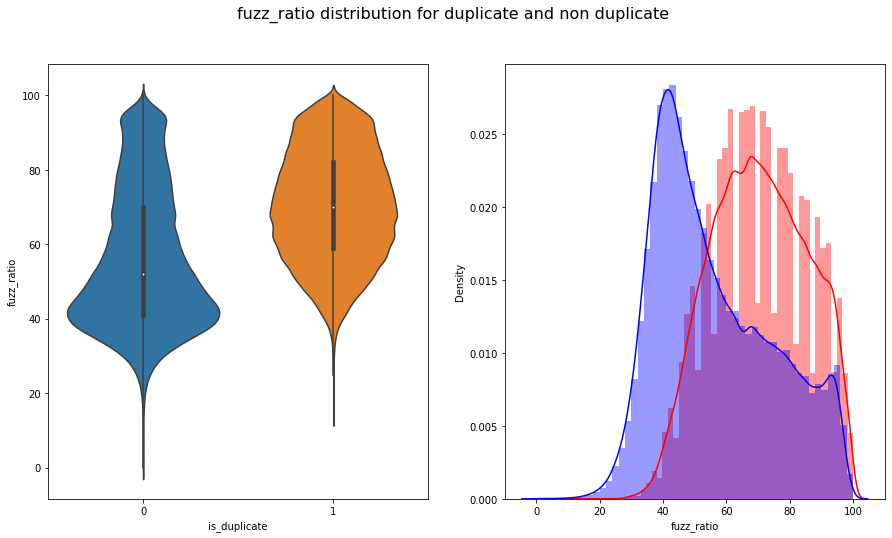

In [43]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'] , label = "0" , color = 'blue' )

plt.suptitle("fuzz_ratio distribution for duplicate and non duplicate", fontsize = 16)
plt.show()

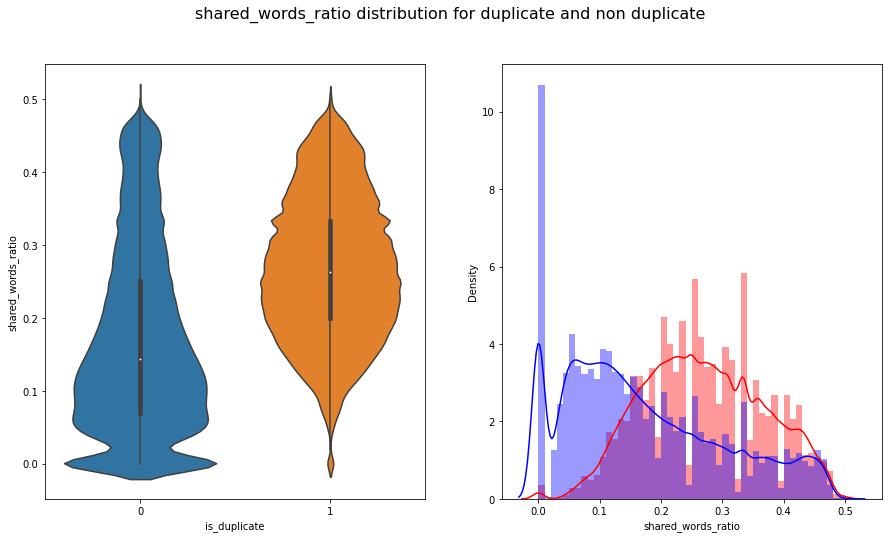

In [44]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'shared_words_ratio', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['shared_words_ratio'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['shared_words_ratio'] , label = "0" , color = 'blue' )

plt.suptitle("shared_words_ratio distribution for duplicate and non duplicate", fontsize = 16)
plt.show()

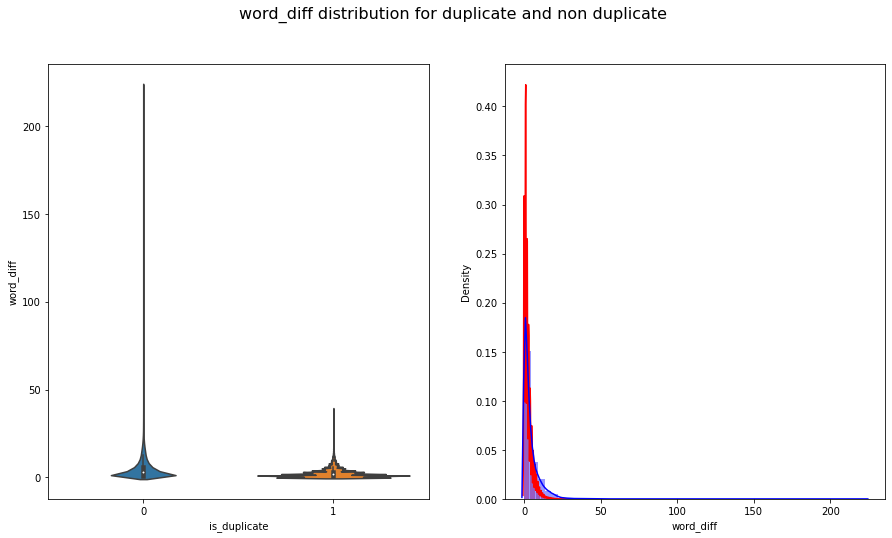

In [45]:
plt.figure(figsize=(15, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_diff', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_diff'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_diff'] , label = "0" , color = 'blue' )

plt.suptitle("word_diff distribution for duplicate and non duplicate", fontsize = 16)
plt.show()

# Text Preprocessing Techniques

* Expand Contractions
* Lower Case
* Remove Punctuations
* Remove Stopwords
* Stemming and Lemmatization
* Remove White spaces

In [46]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how does",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
" u ": " you ",
" ur ": " your ",
" n ": " and "}

In [47]:
lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))
class text_preprocessing:
    def __init__(self):
        pass
        
    def cont_to_exp(self,x): # Contraction to expansion
        if type(x) is str:
            x = x.replace("\w*\\", "")
            for key in contractions:
                value = contractions[key]
                x = x.replace(key, value)
            return x
        else:
            return x
    
    def to_lower(self, text):
        return text.lower()
    
    def special_char_removal(self, x):
        return re.sub(r"[^\w+ ]+", "", x)
    
    def remove_stopwords(self,text):
        return " ".join([word for word in str(text).split() if word not in stop_words])
    
    def lemmatize_words(self, text):
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    
    def digit_removal(self, text): #Some questions are like maths equaltions
        return re.sub('\w+\d+\w*','',text)
    
    def removing_spaces(self, text):
        return text.strip()

In [48]:
pro = text_preprocessing()

In [49]:
df["question1"] = df["question1"].apply(lambda x: pro.cont_to_exp(x))
df["question1"] = df["question1"].apply(lambda x: pro.to_lower(x))
df["question1"] = df["question1"].apply(lambda x: pro.special_char_removal(x))
df["question1"] = df["question1"].apply(lambda x: pro.remove_stopwords(x))
df["question1"] = df["question1"].apply(lambda x: pro.lemmatize_words(x))
df["question1"] = df["question1"].apply(lambda x: pro.digit_removal(x))
df["question1"] = df["question1"].apply(lambda x: pro.removing_spaces(x))


df["question2"] = df["question2"].apply(lambda x: pro.cont_to_exp(x))
df["question2"] = df["question2"].apply(lambda x: pro.to_lower(x))
df["question2"] = df["question2"].apply(lambda x: pro.special_char_removal(x))
df["question2"] = df["question2"].apply(lambda x: pro.remove_stopwords(x))
df["question2"] = df["question2"].apply(lambda x: pro.lemmatize_words(x))
df["question2"] = df["question2"].apply(lambda x: pro.digit_removal(x))
df["question2"] = df["question2"].apply(lambda x: pro.removing_spaces(x))

In [50]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,char_count1,char_count2,word_count1,word_count2,...,words_total,shared_words_ratio,first_word_eq,last_word_eq,fuzz_ratio,fuzz_partial_ratio,fuzz_token_sort_ratio,fuzz_token_set_ratio,avg_words,word_diff
0,0,1,2,step step guide invest share market india,step step guide invest share market,0,66,57,14,12,...,26,0.384615,1,0,93,98,93,100,13.0,2
1,1,3,4,story kohinoor kohinoor diamond,happen indian government stole kohinoor kohino...,0,51,88,8,13,...,21,0.190476,1,0,65,73,63,86,10.5,5
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0,73,59,14,10,...,24,0.125000,1,0,55,53,66,66,12.0,4
3,3,7,8,mentally lonely solve,find remainder divided,0,50,65,11,9,...,20,0.000000,0,0,28,30,36,36,10.0,2
4,4,9,10,one dissolve water quikly sugar salt methane c...,fish survive salt water,0,76,39,13,7,...,20,0.100000,1,0,45,54,47,67,10.0,6


# Generating Word embeddings

## 1. Word2Vec

In [51]:
nlp = spacy.load('en_core_web_lg')

In [52]:
def get_vec(string):
    doc = nlp(string)
    vec = doc.vector
    return vec

**Uncomment the below code to get the final dataframe having word2vec embeddings and derived features**

In [53]:
# %%time
# df["q1_vector"] = df["question1"].apply(lambda x: get_vec(x))
# df["q2_vector"] = df["question2"].apply(lambda x: get_vec(x))

# df_q1 = pd.DataFrame(df.q1_vector.values.tolist(), index= df.index)
# df_q2 = pd.DataFrame(df.q2_vector.values.tolist(), index= df.index)

# df_features = df.drop(['id', 'question1', 'question2',
#                       'q1_vector', 'q2_vector'], axis = 'columns')

# print("Number of independent features generated after feature engineering:", df_features.shape[1] - 2)
# print("Features generated through word2vec of question_1:", df_q1.shape[1])
# print("Features generated through word2vec of question_2:", df_q2.shape[1])

# final_df = pd.concat([df_features, df_q1, df_q2], axis = 'columns')

In [54]:
from IPython.display import HTML

def create_download_link(filename, title = "Download CSV file"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)

In [55]:
# create a link to download the dataframe which was saved with .to_csv method

# create_download_link(filename='word2vec.csv')

## 2. Sent2Vec transformer

In [56]:
pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 KB 562.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=a2b6b58f622090a3b2408bf7a41e2046f7fc94d3fbf561d59d88f59eaba354d8
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
Note: you may need to restart the kernel to use updated packages.


[Click here to read more about the below transformer](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L3-v2)

<br>
Reason to use this particular transformer:<br>
* It occupies lesser memory.<br>
* It was having far better speed than any other transformer.

In [57]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L3-v2')
# Model Size:- 61MB, Model Speed:- 19000, Avg Performance:- 50.74

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [58]:
def get_sent_vec(string):
    embedding = model.encode(string,show_progress_bar = False)
    return embedding

**Uncomment the below code to get the final dataframe having sent2vec embeddings and derived features**

In [59]:
# %%timeit
# df["q1_vector"] = df["question1"].apply(lambda x: get_sent_vec(x))
# df["q2_vector"] = df["question2"].apply(lambda x: get_sent_vec(x))

# df_q1 = pd.DataFrame(df.q1_vector.values.tolist(), index= df.index)
# df_q2 = pd.DataFrame(df.q2_vector.values.tolist(), index= df.index)

# df_features = df.drop(['id', 'question1', 'question2',
#                       'q1_vector', 'q2_vector'], axis = 'columns')

# final_df = pd.concat([df_features, df_q1, df_q2], axis = 'columns')

In [60]:
# create a link to download the dataframe which was saved with .to_csv method

# create_download_link(filename='sent2vec.csv')

In [61]:
w2v_df = pd.read_csv("../input/embeddings/embeddings_data/word2vec.csv")
sent2v_df = pd.read_csv("../input/embeddings/embeddings_data/sent2vec.csv")

In [62]:
w2v_df.shape, sent2v_df.shape

((404290, 618), (404290, 786))

**Since, the data is very huge, the preprocessing on CSV will take a lot of time, so here I am converting my data into hdf5 which stores the data into hierarchical order. Also, I am using vaex as it works efficiently on large datasets**

In [63]:
vaexdf_w2v = vaex.from_pandas(w2v_df)
vaexdf_sent2v = vaex.from_pandas(sent2v_df)

vaexdf_w2v.export_hdf5('word2vec.hdf5')
vaexdf_sent2v.export_hdf5('sent2vec.hdf5')

vaexdf_w2v = vaex.open("./word2vec.hdf5")
vaexdf_sent2v = vaex.open("./sent2vec.hdf5")

**Taking random 100,000 records for fast model training**

In [64]:
vaexdf_w2v = vaexdf_w2v.shuffle(random_state = 0)
vaexdf_sent2v = vaexdf_sent2v.shuffle(random_state = 1)

vaexdf_w2v = vaexdf_w2v[:100000]
vaexdf_sent2v = vaexdf_sent2v[:100000]

# Train Test Split

In [65]:
w2v_train , w2v_test = vaexdf_w2v.ml.train_test_split(test_size = 0.2)
sent2v_train, sent2v_test = vaexdf_sent2v.ml.train_test_split(test_size = 0.2)

In [66]:
w2v_train.shape, w2v_test.shape, sent2v_train.shape, sent2v_test.shape

((80000, 618), (20000, 618), (80000, 786), (20000, 786))

**Checking class distribution in train and test data**

In [67]:
print("-"*10, "Distribution of output variable in WORD2VEC train data", "-"*10)
train_distr = Counter(w2v_train['is_duplicate'].to_pandas_series())
train_len = len(w2v_train['is_duplicate'].to_pandas_series())
print("\t Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)

print("\n")

print("-"*10, "Distribution of output variable in WORD2VEC test data", "-"*10)
test_distr = Counter(w2v_test['is_duplicate'].to_pandas_series())
test_len = len(w2v_test['is_duplicate'].to_pandas_series())
print("\t Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in WORD2VEC train data ----------
	 Class 0:  0.6306 Class 1:  0.3694


---------- Distribution of output variable in WORD2VEC test data ----------
	 Class 0:  0.3713 Class 1:  0.3713


In [68]:
print("-"*10, "Distribution of output variable in SENT2VEC train data", "-"*10)
train_distr = Counter(sent2v_train['is_duplicate'].to_pandas_series())
train_len = len(sent2v_train['is_duplicate'].to_pandas_series())
print("\t Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)

print("\n")

print("-"*10, "Distribution of output variable in SENT2VEC test data", "-"*10)
test_distr = Counter(sent2v_test['is_duplicate'].to_pandas_series())
test_len = len(sent2v_test['is_duplicate'].to_pandas_series())
print("\t Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in SENT2VEC train data ----------
	 Class 0:  0.63035 Class 1:  0.36965


---------- Distribution of output variable in SENT2VEC test data ----------
	 Class 0:  0.3683 Class 1:  0.3683


# Scaling

In [69]:
w2v_features = list(w2v_train.column_names)
w2v_features.remove('is_duplicate')

sent2v_features = list(sent2v_train.column_names)
sent2v_features.remove('is_duplicate')

In [70]:
len(w2v_features), len(sent2v_features)

(617, 785)

In [71]:
# Feature Scaling of both the dataframes

scaler_w2v = vaex.ml.MinMaxScaler(features = w2v_features, prefix = "scaled_")
scaler_sent2v = vaex.ml.MinMaxScaler(features = sent2v_features, prefix = "scaled_")

# Fitting the scaler to the train set
scaler_w2v.fit(w2v_train)
scaler_sent2v.fit(sent2v_train)

# Getting the transformed training and test set
w2v_train_trans = scaler_w2v.transform(w2v_train)
w2v_test_trans = scaler_w2v.transform(w2v_test)

sent2v_train_trans = scaler_sent2v.transform(sent2v_train)
sent2v_test_trans = scaler_sent2v.transform(sent2v_test)

# Removing the initial non scaled features from the scaled dataframe
w2v_train_trans.drop(w2v_features, inplace = True)
w2v_test_trans.drop(w2v_features, inplace = True)

sent2v_train_trans.drop(sent2v_features, inplace = True)
sent2v_test_trans.drop(sent2v_features, inplace = True)

#,is_duplicate,scaled_qid1,scaled_qid2,scaled_char_count1,scaled_char_count2,scaled_word_count1,scaled_word_count2,scaled_words_common,scaled_words_total,scaled_shared_words_ratio,scaled_first_word_eq,scaled_last_word_eq,scaled_fuzz_ratio,scaled_fuzz_partial_ratio,scaled_fuzz_token_sort_ratio,scaled_fuzz_token_set_ratio,scaled_avg_words,scaled_word_diff,scaled_0,scaled_1,scaled_2,scaled_3,scaled_4,scaled_5,scaled_6,scaled_7,scaled_8,scaled_9,scaled_10,scaled_11,scaled_12,scaled_13,scaled_14,scaled_15,scaled_16,scaled_17,scaled_18,scaled_19,scaled_20,scaled_21,scaled_22,scaled_23,scaled_24,scaled_25,scaled_26,scaled_27,scaled_28,scaled_29,scaled_30,scaled_31,scaled_32,scaled_33,scaled_34,scaled_35,scaled_36,scaled_37,scaled_38,scaled_39,scaled_40,scaled_41,scaled_42,scaled_43,scaled_44,scaled_45,scaled_46,scaled_47,scaled_48,scaled_49,scaled_50,scaled_51,scaled_52,scaled_53,scaled_54,scaled_55,scaled_56,scaled_57,scaled_58,scaled_59,scaled_60,scaled_61,scaled_62,scaled_63,scaled_64,scaled_65,scaled_66,scaled_67,scaled_68,scaled_69,scaled_70,scaled_71,scaled_72,scaled_73,scaled_74,scaled_75,scaled_76,scaled_77,scaled_78,scaled_79,scaled_80,scaled_81,...,scaled_284.1,scaled_285.1,scaled_286.1,scaled_287.1,scaled_288.1,scaled_289.1,scaled_290.1,scaled_291.1,scaled_292.1,scaled_293.1,scaled_294.1,scaled_295.1,scaled_296.1,scaled_297.1,scaled_298.1,scaled_299.1,scaled_300.1,scaled_301.1,scaled_302.1,scaled_303.1,scaled_304.1,scaled_305.1,scaled_306.1,scaled_307.1,scaled_308.1,scaled_309.1,scaled_310.1,scaled_311.1,scaled_312.1,scaled_313.1,scaled_314.1,scaled_315.1,scaled_316.1,scaled_317.1,scaled_318.1,scaled_319.1,scaled_320.1,scaled_321.1,scaled_322.1,scaled_323.1,scaled_324.1,scaled_325.1,scaled_326.1,scaled_327.1,scaled_328.1,scaled_329.1,scaled_330.1,scaled_331.1,scaled_332.1,scaled_333.1,scaled_334.1,scaled_335.1,scaled_336.1,scaled_337.1,scaled_338.1,scaled_339.1,scaled_340.1,scaled_341.1,scaled_342.1,scaled_343.1,scaled_344.1,scaled_345.1,scaled_346.1,scaled_347.1,scaled_348.1,scaled_349.1,scaled_350.1,scaled_351.1,scaled_352.1,scaled_353.1,scaled_354.1,scaled_355.1,scaled_356.1,scaled_357.1,scaled_358.1,scaled_359.1,scaled_360.1,scaled_361.1,scaled_362.1,scaled_363.1,scaled_364.1,scaled_365.1,scaled_366.1,scaled_367.1,scaled_368.1,scaled_369.1,scaled_370.1,scaled_371.1,scaled_372.1,scaled_373.1,scaled_374.1,scaled_375.1,scaled_376.1,scaled_377.1,scaled_378.1,scaled_379.1,scaled_380.1,scaled_381.1,scaled_382.1,scaled_383.1
0,0,0.06150090997477353,0.6471101097360794,0.09941520467836257,0.038593481989708404,0.08333333333333333,0.03389830508474576,0.13333333333333333,0.046511627906976744,0.5,0.0,0.0,0.696969696969697,0.7701149425287356,0.69,0.87,0.046511627906976744,0.009216589861751152,0.5222857339334279,0.5565009329692762,0.5906444648952858,0.5651808670934577,0.6550363671721315,0.3780687697788421,0.5323823903234314,0.6317592596650254,0.603315138055619,0.5188497307040301,0.41241300047302293,0.6206822351957095,0.48271559700978756,0.5449368711959904,0.4675293839983056,0.6301741667354156,0.6405719627404608,0.5592998154623526,0.5237301705630731,0.4436893561429415,0.4435362640067569,0.5740640035051424,0.502397969358819,0.7100198936284435,0.30421610800222115,0.5021436393127376,0.5666062489068203,0.5899817086449717,0.5450593109770137,0.6468192920440453,0.4657282225290211,0.5372046556458544,0.534194197630669,0.4270718373081355,0.33447045474732257,0.5064905582596566,0.43239968206753115,0.37602918186782547,0.5456054200184107,0.439550861442695,0.6335194936612284,0.6890895923753134,0.5553063008410822,0.24852963566553868,0.3566124861625457,0.4745821834436782,0.2823768999662619,0.4252631128929636,0.7698091214530772,0.24609384994951738,0.30594841367239584,0.5961696710438054,0.5089094861444479,0.499974301131925,0.4799789156952815,0.41658913977566875,0.7507651452957841,0.44936797516365784,0.24725986952704676,0.5795110280642585,0.5651383902908819,0.4584836021309704,0.6436391764306714,0.18865489453413317,0.2016196000125618,0.4047825755463823,0.

# Logistic Regression and Linear SVM With Hyperparameter Tuning

In [72]:
def sgd_tuned_model(X_train, y_train, X_test, y_test, loss):
    alpha = [10 ** x for x in range(-5, 2)] # This is basically the learning rate, the constant in regularization

    log_error_array=[]
    for i in alpha:
        clf = SGDClassifier(alpha=i, penalty='l2', loss=loss, random_state=0)
        clf.fit(X_train, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)
        predict_y = sig_clf.predict_proba(X_test)
        log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
        print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

    fig, ax = plt.subplots()
    ax.plot(alpha, log_error_array,c='g')
    for i, txt in enumerate(np.round(log_error_array,3)):
        ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
    plt.grid()
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()


    best_alpha = np.argmin(log_error_array)
    clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss=loss, random_state=0)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)

    predict_y = sig_clf.predict_proba(X_train)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
    predict_y = sig_clf.predict_proba(X_test)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    predicted_y =np.argmax(predict_y,axis=1)
    print("Total number of data points :", len(predicted_y))
    plot_confusion_matrix(sig_clf,X_test, y_test, normalize = 'true')

In [73]:
X_train_w2v = w2v_train_trans.drop('is_duplicate').to_pandas_df()
y_train_w2v = w2v_train_trans['is_duplicate'].to_pandas_series()
X_test_w2v = w2v_test_trans.drop('is_duplicate').to_pandas_df()
y_test_w2v = w2v_test_trans['is_duplicate'].to_pandas_series()

X_train_sent2v = sent2v_train_trans.drop('is_duplicate').to_pandas_df()
y_train_sent2v = sent2v_train_trans['is_duplicate'].to_pandas_series()
X_test_sent2v = sent2v_test_trans.drop('is_duplicate').to_pandas_df()
y_test_sent2v = sent2v_test_trans['is_duplicate'].to_pandas_series()

In [74]:
X_train_w2v.shape,X_train_sent2v.shape

((80000, 617), (80000, 785))

For values of alpha =  1e-05 The log loss is: 0.4787689556689473
For values of alpha =  0.0001 The log loss is: 0.4785955848007996
For values of alpha =  0.001 The log loss is: 0.48615197613990385
For values of alpha =  0.01 The log loss is: 0.5077231669339178
For values of alpha =  0.1 The log loss is: 0.5338414055944531
For values of alpha =  1 The log loss is: 0.5440024521453476
For values of alpha =  10 The log loss is: 0.551971562236779


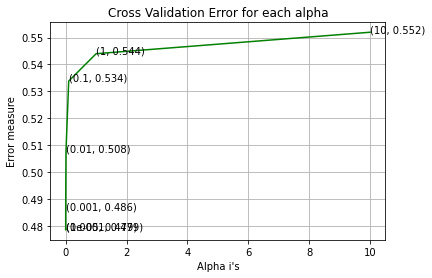

For values of best alpha =  0.0001 The train log loss is: 0.476793304081714
For values of best alpha =  0.0001 The test log loss is: 0.4785955848007996
Total number of data points : 20000


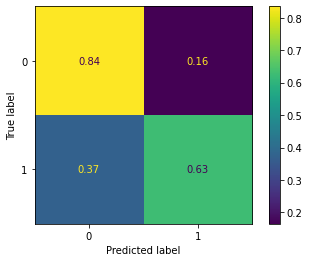

In [75]:
# Implementing LR with tuning on Word2Vec embeddings data
sgd_tuned_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, 'log')

For values of alpha =  1e-05 The log loss is: 0.47273711305494315
For values of alpha =  0.0001 The log loss is: 0.47306468999744394
For values of alpha =  0.001 The log loss is: 0.4800004846970138
For values of alpha =  0.01 The log loss is: 0.4967555038465852
For values of alpha =  0.1 The log loss is: 0.5198072541032006
For values of alpha =  1 The log loss is: 0.5311973696093966
For values of alpha =  10 The log loss is: 0.532380548474772


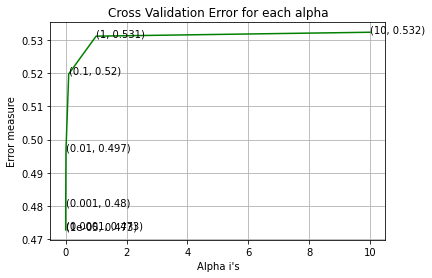

For values of best alpha =  1e-05 The train log loss is: 0.46418053737096926
For values of best alpha =  1e-05 The test log loss is: 0.47273711305494315
Total number of data points : 20000


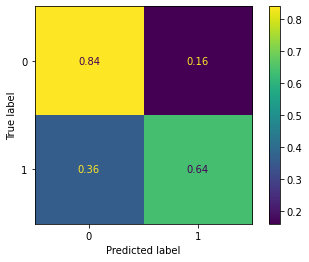

In [76]:
# Implementing LR with tuning on Sent2Vec embeddings data
sgd_tuned_model(X_train_sent2v, y_train_sent2v, X_test_sent2v, y_test_sent2v, 'log')

For values of alpha =  1e-05 The log loss is: 0.4797364678724178
For values of alpha =  0.0001 The log loss is: 0.48037307050803785
For values of alpha =  0.001 The log loss is: 0.48442038775037716
For values of alpha =  0.01 The log loss is: 0.5054099771443592
For values of alpha =  0.1 The log loss is: 0.5366167875770833
For values of alpha =  1 The log loss is: 0.5367479431002696
For values of alpha =  10 The log loss is: 0.5784202041458948


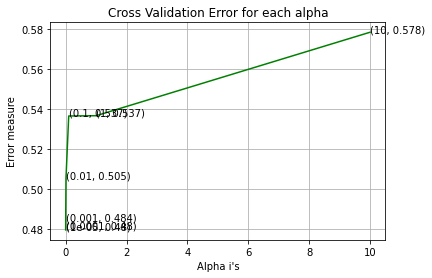

For values of best alpha =  1e-05 The train log loss is: 0.4760571952633389
For values of best alpha =  1e-05 The test log loss is: 0.4797364678724178
Total number of data points : 20000


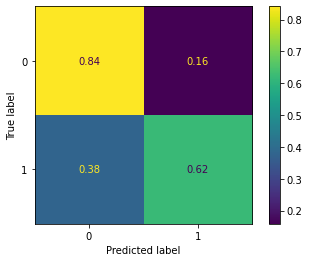

In [77]:
# Implementing Linear SVM with tuning on Word2Vec embeddings data
sgd_tuned_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, 'hinge')

For values of alpha =  1e-05 The log loss is: 0.47351673714862175
For values of alpha =  0.0001 The log loss is: 0.4746202871315053
For values of alpha =  0.001 The log loss is: 0.47913885393800626
For values of alpha =  0.01 The log loss is: 0.49426317183184354
For values of alpha =  0.1 The log loss is: 0.518878593931889
For values of alpha =  1 The log loss is: 0.5196181294801667
For values of alpha =  10 The log loss is: 0.5463652122772703


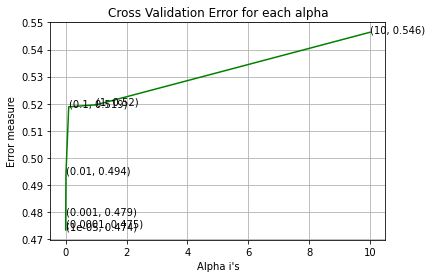

For values of best alpha =  1e-05 The train log loss is: 0.46494784167732023
For values of best alpha =  1e-05 The test log loss is: 0.47351673714862175
Total number of data points : 20000


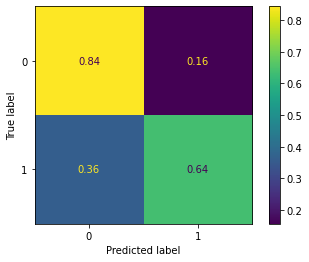

In [78]:
# Implementing Linear SVM with tuning on Sent2Vec embeddings data
sgd_tuned_model(X_train_sent2v, y_train_sent2v, X_test_sent2v, y_test_sent2v, 'hinge')

# Xgboost with hyperparameter tuning

In [79]:
w2v_train.shape, w2v_test.shape

((80000, 618), (20000, 618))

In [80]:
def xgb_classifier(params, X_train, X_test, y_train, y_test):
#     params = {}
#     params['objective'] = 'binary:logistic'
#     params['eval_metric'] = 'logloss'
#     params['eta'] = 0.02
#     params['max_depth'] = 4

    d_train = xgb.DMatrix(X_train, label=y_train)
    d_test = xgb.DMatrix(X_test, label=y_test)

    watchlist = [(d_train, 'train'), (d_test, 'valid')]

    bst = xgb.train(params, d_train, 400, watchlist,verbose_eval= False,early_stopping_rounds=20)

#     xgdmat = xgb.DMatrix(X_train,y_train)
    predict_y = bst.predict(d_test)
    print("The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))

In [81]:
# params for hyperparameter tuning
# w2v_params={
#     "learning_rate"    : [0.0001, 0.001, 0.01, 0.10] ,
#     "max_depth"        : [5, 10, 20, 100, 200],
#     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
#     "n_estimators" : [50, 100, 150, 200]
# }

# sent2v_params={
#     "learning_rate"    : [0.0001, 0.001, 0.01, 0.10],
#     "max_depth"        : [4, 5, 10, 15, 20],
#     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
#     "n_estimators" : [50, 100, 150, 200]
# }

In [82]:
# # Implementing XGB classifier with tuning on Word2Vec embeddings data
# X_train = sent2v_train_trans.drop('is_duplicate').to_pandas_df()
# y_train = sent2v_train_trans['is_duplicate'].to_pandas_series()
# X_test = sent2v_test_trans.drop('is_duplicate').to_pandas_df()
# y_test = sent2v_test_trans['is_duplicate'].to_pandas_series()

# clf = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss')

# random_search = RandomizedSearchCV(clf,
#                                    param_distributions = sent2v_params,
#                                    n_iter = 3,
#                                    n_jobs = -1,
#                                    cv = 5,
#                                    verbose = 3)
# random_search.fit(X_train, y_train)

# random_search.best_params_

Best params using random search cv for Xgboost on W2V embeddings: <br>
{'n_estimators': 200,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 0.3}

In [83]:
# Implementing XGBclasifier on Word2Vec data

params = {'objective' : 'binary:logistic', 
          'eval_metric' : 'logloss',
          'n_parameters' : 200,
          'max_depth' : 10, 
          'learning_rate' : 0.1,
          'colsample_bytree' : 0.3}

X_train = w2v_train.drop('is_duplicate').to_pandas_df()
y_train = w2v_train['is_duplicate'].to_pandas_series()
X_test = w2v_test.drop('is_duplicate').to_pandas_df()
y_test = w2v_test['is_duplicate'].to_pandas_series()

xgb_classifier(params, X_train, X_test, y_train, y_test)

[18:05:42] WARNING: ../src/learner.cc:627: 
Parameters: { "n_parameters" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


The test log loss is: 0.3686480382987768


Best params using random search cv for xgboost on Sent2Vec embeddings:<br>
{'n_estimators': 100,
 'max_depth': 15,
 'learning_rate': 0.01,
 'colsample_bytree': 0.5}

In [84]:
# Implementing XGBclasifier on Sent2Vec data
params = {'objective' : 'binary:logistic', 
          'eval_metric' : 'logloss',
          'n_parameters' : 100,
          'max_depth' : 15, 
          'learning_rate' : 0.01,
          'colsample_bytree' : 0.5}

X_train = sent2v_train.drop('is_duplicate').to_pandas_df()
y_train = sent2v_train['is_duplicate'].to_pandas_series()
X_test = sent2v_test.drop('is_duplicate').to_pandas_df()
y_test = sent2v_test['is_duplicate'].to_pandas_series()

xgb_classifier(params, X_train, X_test, y_train, y_test)

[18:18:17] WARNING: ../src/learner.cc:627: 
Parameters: { "n_parameters" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


The test log loss is: 0.3861799738774076
